In [1]:
import torch

# print("Cuda available:", torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))

In [2]:
from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor

device = "cpu"

image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter", 
    subfolder="models/image_encoder",
    torch_dtype=torch.float16
).to(device)

image_encoder

`torch_dtype` is deprecated! Use `dtype` instead!


CLIPVisionModelWithProjection(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(257, 1280)
    )
    (pre_layrnorm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-31): 32 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (layer_norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1280, out_features=51

In [3]:
clip_image_size = image_encoder.config.image_size
feature_extractor = CLIPImageProcessor(size=clip_image_size, crop_size=clip_image_size)

feature_extractor

CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [4]:
from diffusers.utils import load_image
from PIL import Image

def get_embeddings(images: list):
    image_features = feature_extractor(images=images, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        outputs = image_encoder(image_features, output_hidden_states=True)
        embeddings = outputs.hidden_states[-2]
        #embeddings = image_encoder(image_features, output_hidden_states=False)

    return embeddings

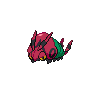

In [5]:
venipede_image = load_image("./venipede_white.png")
venipede_image

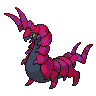

In [6]:
scolipede_image = load_image("./scolipede_white.png")
scolipede_image

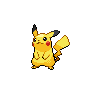

In [7]:
pikachu_image = load_image("./pikachu_white.png")
pikachu_image

In [8]:
image_embeds = get_embeddings([venipede_image, scolipede_image, pikachu_image])
image_embeds.shape

torch.Size([3, 257, 1280])

In [9]:
nsamples, nx, ny = image_embeds.shape
image_embeds = image_embeds.reshape(nsamples, nx*ny)
image_embeds.shape

torch.Size([3, 328960])

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
Xt = pca.fit_transform(image_embeds.cpu())
Xt.shape

(3, 3)

In [11]:
Xt

array([[ 6.71480346e+01,  1.45991204e+02, -2.06671604e-12],
       [-2.01798832e+02, -2.92905944e+01, -2.06671604e-12],
       [ 1.34650797e+02, -1.16700610e+02, -2.06671604e-12]])

In [12]:
names = ["venipede", "scolipede", "pikachu"]
names

['venipede', 'scolipede', 'pikachu']

In [13]:
import polars as pl

df = pl.from_numpy(Xt, schema=["pc1", "pc2", "pc3"], orient="row")
df = df.with_columns(
    name=pl.Series(names),
    ind=pl.Series(range(len(names)))
)

df

pc1,pc2,pc3,name,ind
f64,f64,f64,str,i64
67.148035,145.991204,-2.0667e-12,"""venipede""",0
-201.798832,-29.290594,-2.0667e-12,"""scolipede""",1
134.650797,-116.70061,-2.0667e-12,"""pikachu""",2


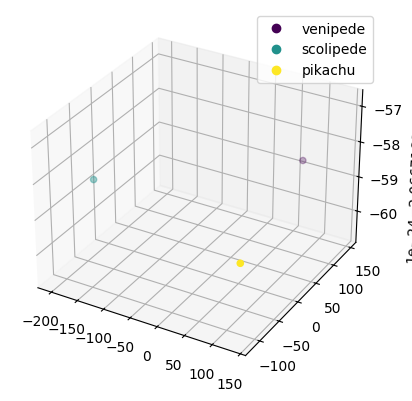

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot(projection='3d')
plot = ax.scatter(data=df, xs="pc1", ys="pc2", zs="pc3", c="ind", cmap='viridis')
plt.legend(handles=plot.legend_elements()[0], labels=names)
plt.show()

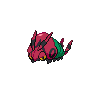

In [15]:
from PIL import Image

def get_pokemon_images(start=0, end=100, dir="/home/kojo/Code/sprites/sprites/pokemon/versions/generation-v/black-white/"):
    images = []
    for i in range(start, end+1):
        base_image = Image.open(f"{dir}/{i}.png")
        transparency_index = base_image.info.get("transparency")
        mask = base_image.point(lambda i: 0 if i == transparency_index else 255, mode='L')
        new_image = Image.new("RGBA", base_image.size, "WHITE")
        new_image.paste(base_image, (0, 0), mask)
        images.append(new_image)
    
    return images

pokemon_images = get_pokemon_images(494, 649)
pokemon_images[49]

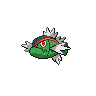

In [16]:
pokemon_images[56]

In [17]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

# torch.cuda.empty_cache()

In [18]:
image_embeds = get_embeddings(pokemon_images)
image_embeds.shape

torch.Size([156, 257, 1280])

In [25]:
nsamples, nx, ny = image_embeds.shape
image_embeds = image_embeds.reshape(nsamples, nx*ny)
image_embeds.shape

ValueError: not enough values to unpack (expected 3, got 2)

In [27]:
pca = PCA(n_components=3)
Xt = pca.fit_transform(image_embeds.cpu())
Xt.shape

(156, 3)

In [28]:
import polars as pl

df = pl.from_numpy(Xt, schema=["pc1", "pc2", "pc3"], orient="row")
df = df.with_columns(
    #name=pl.Series(names),
    ind=pl.Series(range(Xt.shape[0]))
)

df

pc1,pc2,pc3,ind
f64,f64,f64,i64
30.241862,35.764647,-27.274857,0
87.716114,-26.444035,-12.006527,1
12.537112,40.431912,-45.614383,2
-76.372917,-62.630077,-13.180863,3
89.686964,-26.891564,-8.374441,4
…,…,…,…
-80.957734,-58.519303,-8.417074,151
-79.592753,-51.011321,26.273051,152
-16.016209,67.183331,-17.766004,153


In [29]:
Xt[0][0]

np.float64(30.241862334841965)

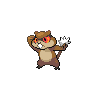

In [46]:
pokemon_images[10]

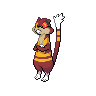

In [47]:
pokemon_images[11]

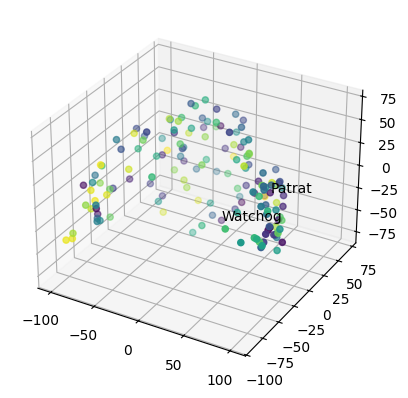

In [48]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot(projection='3d')
plot = ax.scatter(data=df, xs="pc1", ys="pc2", zs="pc3", c="ind", cmap='viridis')
#plt.legend(handles=plot.legend_elements()[0], labels=range(Xt.shape[0]))
p1 = 10
p2 = 11
ax.text(Xt[p1][0], Xt[p1][1], Xt[p1][2], "Patrat")
ax.text(Xt[p2][0], Xt[p2][1], Xt[p2][2], "Watchog")
plt.show()

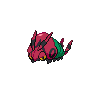

In [49]:
pokemon_images[49]

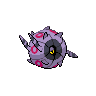

In [50]:
pokemon_images[50]

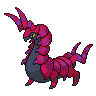

In [51]:
pokemon_images[51]

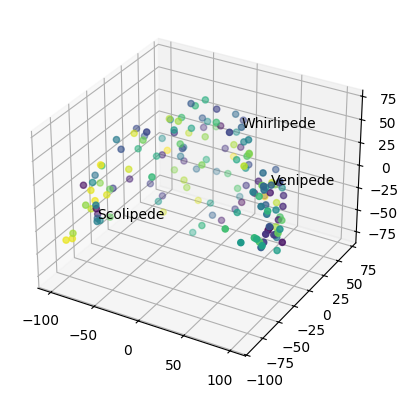

In [54]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
plot = ax.scatter(data=df, xs="pc1", ys="pc2", zs="pc3", c="ind", cmap='viridis')
#plt.legend(handles=plot.legend_elements()[0], labels=range(Xt.shape[0]))
p1 = 49
p2 = 50
p3 = 51
ax.text(Xt[p1][0], Xt[p1][1], Xt[p1][2], "Venipede")
ax.text(Xt[p2][0], Xt[p2][1], Xt[p2][2], "Whirlipede")
ax.text(Xt[p3][0], Xt[p3][1], Xt[p3][2], "Scolipede")
plt.show()

In [57]:
def lerp(vec_1, vec_2, frac):
  return vec_1 + (vec_2 - vec_1) * frac

new_vec = lerp(Xt[49], Xt[51], 0.5)

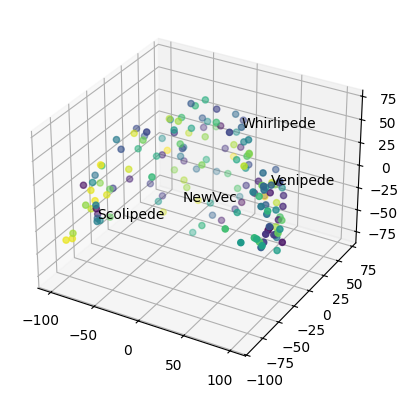

In [58]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
plot = ax.scatter(data=df, xs="pc1", ys="pc2", zs="pc3", c="ind", cmap='viridis')
#plt.legend(handles=plot.legend_elements()[0], labels=range(Xt.shape[0]))
p1 = 49
p2 = 50
p3 = 51
ax.text(Xt[p1][0], Xt[p1][1], Xt[p1][2], "Venipede")
ax.text(Xt[p2][0], Xt[p2][1], Xt[p2][2], "Whirlipede")
ax.text(Xt[p3][0], Xt[p3][1], Xt[p3][2], "Scolipede")
ax.text(new_vec[0], new_vec[1], new_vec[2], "NewVec")
plt.show()

In [59]:
import numpy as np

def slerp(v0, v1, t, DOT_THRESHOLD=0.9995):
    '''
    Spherical linear interpolation
    Args:
        t (float/np.ndarray): Float value between 0.0 and 1.0
        v0 (np.ndarray): Starting vector
        v1 (np.ndarray): Final vector
        DOT_THRESHOLD (float): Threshold for considering the two vectors as
                               colineal. Not recommended to alter this.
    Returns:
        v2 (np.ndarray): Interpolation vector between v0 and v1
    '''
    c = False
    if not isinstance(v0,np.ndarray):
        c = True
        v0 = v0.detach().cpu().numpy()
    if not isinstance(v1,np.ndarray):
        c = True
        v1 = v1.detach().cpu().numpy()
    # Copy the vectors to reuse them later
    v0_copy = np.copy(v0)
    v1_copy = np.copy(v1)
    # Normalize the vectors to get the directions and angles
    v0 = v0 / np.linalg.norm(v0)
    v1 = v1 / np.linalg.norm(v1)
    # Dot product with the normalized vectors (can't use np.dot in W)
    dot = np.sum(v0 * v1)
    # If absolute value of dot product is almost 1, vectors are ~colineal, so use lerp
    if np.abs(dot) > DOT_THRESHOLD:
        return lerp(t, v0_copy, v1_copy)
    # Calculate initial angle between v0 and v1
    theta_0 = np.arccos(dot)
    sin_theta_0 = np.sin(theta_0)
    # Angle at timestep t
    theta_t = theta_0 * t
    sin_theta_t = np.sin(theta_t)
    # Finish the slerp algorithm
    s0 = np.sin(theta_0 - theta_t) / sin_theta_0
    s1 = sin_theta_t / sin_theta_0
    v2 = s0 * v0_copy + s1 * v1_copy
    if c:
        res = torch.from_numpy(v2).to("cuda")
    else:
        res = v2
    return res

new_vec = slerp(Xt[49], Xt[51], 0.5)

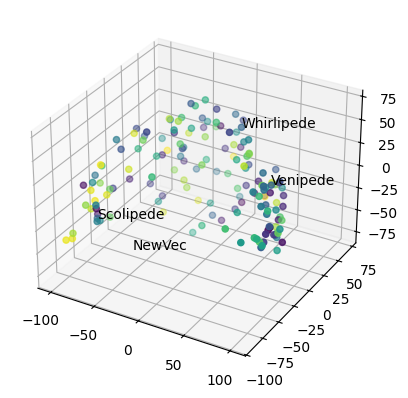

In [62]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
plot = ax.scatter(data=df, xs="pc1", ys="pc2", zs="pc3", c="ind", cmap='viridis')
#plt.legend(handles=plot.legend_elements()[0], labels=range(Xt.shape[0]))
p1 = 49
p2 = 50
p3 = 51
ax.text(Xt[p1][0], Xt[p1][1], Xt[p1][2], "Venipede")
ax.text(Xt[p2][0], Xt[p2][1], Xt[p2][2], "Whirlipede")
ax.text(Xt[p3][0], Xt[p3][1], Xt[p3][2], "Scolipede")
ax.text(new_vec[0], new_vec[1], new_vec[2], "NewVec")
plt.show()